# Image Processing Lab05

## Import

In [41]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Input
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob

## 5.1 Data Preparation

In [42]:
filenames = glob.glob("face_data/*/*.jpg")
len(filenames)

3203

In [43]:
# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
all_images = []
for img_path in filenames:
    img = image.load_img(img_path, target_size=(90, 90), interpolation="nearest")
    # convert the image to an array
    img = image.img_to_array(img)
    # Normalized color imageimg
    img = img/255
    all_images.append(img)

all_images = np.array(all_images)
all_images.shape

(3203, 90, 90, 3)

In [44]:
# split data into train and validation data
train_x, test_x = train_test_split(all_images, test_size=0.3, random_state=32)
train_x, val_x = train_test_split(train_x, test_size=0.3, random_state=32)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1569, 90, 90, 3)
(673, 90, 90, 3)
(961, 90, 90, 3)


## 5.2 Add Noise

In [45]:
noise_factor = 0.3

In [46]:
Nmean = 0
Nstd = 1

In [47]:
# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))
x_val_noisy = val_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))
x_test_noisy = test_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))
print(x_train_noisy.shape)
print(x_val_noisy.shape)
print(x_test_noisy.shape)

(1569, 90, 90, 3)
(673, 90, 90, 3)
(961, 90, 90, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


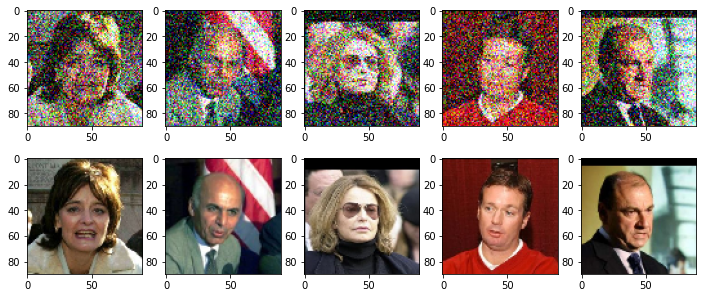

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=5,  figsize=(12, 5))

ax[0, 0].imshow(x_train_noisy[1])
ax[1, 0].imshow(train_x[1])

ax[0, 1].imshow(x_train_noisy[2])
ax[1, 1].imshow(train_x[2])

ax[0, 2].imshow(x_train_noisy[3])
ax[1, 2].imshow(train_x[3])

ax[0, 3].imshow(x_train_noisy[4])
ax[1, 3].imshow(train_x[4])

ax[0, 4].imshow(x_train_noisy[5])
ax[1, 4].imshow(train_x[5])
plt.show()

## 5.3 AutoEncoder Model

In [49]:
# กำหนด Encoder Architecture
input_img = Input(shape=(90, 90, 3))
# Encoding Architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D((2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

In [50]:
# กำหนด Decoder Architecture
# Decoding Architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

In [51]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 256)       7168      
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        36928     
                                                           

In [65]:
# กำหนด Training parameter
epochs = 4
batch_size = 32
early_stopper = EarlyStopping(monitor="val_loss", mode="min", verbose=1)

In [66]:
# เริ่มการ Training
history = autoencoder.fit(x=x_train_noisy, 
                            y=train_x, 
                            batch_size=batch_size,
                            epochs=epochs, 
                            shuffle=True, 
                            validation_data=(x_val_noisy, val_x), 
                            callbacks=[early_stopper])

Epoch 1/4
50/50 [==============================] - 15s 300ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 2/4
50/50 [==============================] - 15s 296ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 2: early stopping


In [67]:
# ทดสอบ autoencoder model ด้วย validation
predictions = autoencoder.predict(x_test_noisy)
predictions.shape

(961, 90, 90, 3)

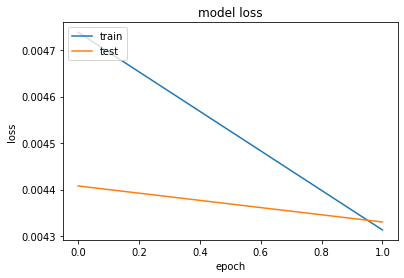

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

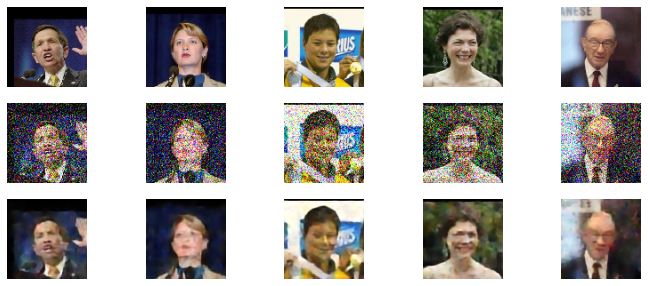

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=5,  figsize=(12, 5))

for i in range(5):
    ax[0, i].imshow(test_x[i+1])
    ax[0, i].axis('off')

    ax[1, i].imshow(x_test_noisy[i+1])
    ax[1, i].axis('off')

    ax[2, i].imshow(predictions[i+1])
    ax[2, i].axis('off')
    